# Application of the Nearest Advocate method for clock-drift correction on real event-based time-series data

**Methods:**
1. Nearest Advocate (NAd): dense, different sparse-factors  

**Data**

One night of the VSL heart beat data.

In [1]:
import os
import time

import numpy as np
np.random.seed(0)
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

from multiprocessing import Pool
from numba import jit, njit, prange

from scipy import stats
import sklearn.metrics
from sklearn.model_selection import GroupKFold
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import HuberRegressor, LinearRegression

# Load methods
%matplotlib inline

In [2]:
# loading own packages
from utils import moving_aggregation, moving_aggregation_nb
from data_loader import load_heart_beats, load_breath_rate, load_step_rate

In [3]:
# directories to load
PATH_HEART_RATE_DATA = "../data/HeartBeatData"
PATH_BREATH_RATE_DATA = "../data/BreathRateData"
PATH_STEP_RATE_DATA = "../data/StepRateData"

# parameters to semi-simulate data
# OFFSET = np.pi  # this is randomly sampled now
SIGMA = 0.1

# parameters for Nearest-Advocate
DIST_MAX = -1           # use the default values for dist_max and dist_padding of nearest_advocate
REGULATE_PADDINGS = True  # regulate the paddings in nearest_advocate
TD_MAX = 300.              # search space of 10 minutes
TD_MIN = -300.
SAMPLES_PER_S = 20.        # precision of the search space (for steps of mean freq 0.5s)

# for the clock drift correction
SPECTROSCOPY_XVAL_DT = 0.1  # Time steps for the spectroscopy representation
FILTER_LARGE_DIST = False  # filter too large distances between events
WINDOW_LENGTH = 40
SLIDING_LENGTH = 5
BANDWIDTH = 60
SPS_ADAPTATION_FACTOR = 0.995

# Config for Synchronize_file
MAX_N_WIN_SYNCS = 10
MAE_THRESHOLD = 1.0
MAX_TRIALS = 3
SYNCED_POSTFIX = ""  # ending of the synced file in SYNC_PATH

## Data

### Load the datasets

In [4]:
heart_beat_dataset = load_heart_beats(path_to_dir=PATH_HEART_RATE_DATA, verbose=1)

Loading files S18_11_nn.txt and S18_1_beats_synced.csv.
Loading files S18_21_nn.txt and S18_2_beats_synced.csv.
Loading files S19_11_nn.txt and S19_1_beats_synced.csv.
Loading files S20_11_nn.txt and S20_1_beats_synced.csv.
Loading files S20_21_nn.txt and S20_2_beats_synced.csv.
Loading files S21_11_nn.txt and S21_1_beats_synced.csv.
Loading files S21_21_nn.txt and S21_2_beats_synced.csv.
Loading files S23_11_nn.txt and S23_1_beats_synced.csv.
Loading files S23_21_nn.txt and S23_2_beats_synced.csv.
Loading files S24_11_nn.txt and S24_1_beats_synced.csv.
Loading files S24_21_nn.txt and S24_2_beats_synced.csv.
Loading files S26_11_nn.txt and S26_1_beats_synced.csv.
Loading files S27_11_nn.txt and S27_1_beats_synced.csv.
Loading files S28_11_nn.txt and S28_1_beats_synced.csv.
Loading files S28_21_nn.txt and S28_2_beats_synced.csv.
Loading files S29_11_nn.txt and S29_1_beats_synced.csv.
Loading files S29_21_nn.txt and S29_2_beats_synced.csv.


In [5]:
# breath_rate_dataset = load_breath_rate(path_to_dir=PATH_BREATH_RATE_DATA, verbose=1)

In [6]:
# step_rate_dataset = load_step_rate(path_to_dir=PATH_STEP_RATE_DATA, verbose=1)

In [7]:
# dataset_full = (heart_beat_dataset + breath_rate_dataset + step_rate_dataset)

## Function to semi-simulate the data

In [8]:
def modify_timeseries(arr: np.ndarray, offset: float=0, subselect_length=None, sigma: float=0.0, fraction: float=1.0, time_warp_scale=0.0):
    """Modify a event-based timeseries in order generate semi-simulated data.
    
    Parameters
    ----------
    arr: np.ndarray
        Array to modify
    offset: float
        Offset to shift the time-series
    sigma: float
        Amount of noise, relative to the median difference of subsequent events
    fraction: float
        Fraction of events used
        
    Returns
    -------
    arr_modified : np.ndarray
        Modified array
    """
    arr_mod = arr.copy()
    
    # shift the array
    arr_mod += offset
    
    # select part
    if subselect_length:
        start_idx = np.random.randint(0, max(1, len(arr_mod)-subselect_length))
        arr_mod = arr_mod[start_idx:start_idx+subselect_length]
            
    # add gaussian noise to the events
    arr_mod = arr_mod + np.random.normal(loc=0, scale=sigma*np.median(np.diff(arr)), size=len(arr_mod))
    
    # sort the array to maintain continuity
    arr_mod.sort()
    
    # select the fraction of events
    if fraction < 1.0:
        arr_mod = arr_mod[np.random.random(len(arr_mod))<fraction]
        
    # linear time-warping
    if time_warp_scale > 0.0:
        pivot = arr_mod[len(arr_mod)//2]
        # warp_scale = np.random.normal(loc=1, scale=time_warp_scale)
        if np.random.rand() > 0.5:
            warp_scale = 1 + time_warp_scale
        else:
            warp_scale = 1 - time_warp_scale
        arr_mod = (arr_mod-pivot) * warp_scale + pivot

    return arr_mod

modify_timeseries(arr=heart_beat_dataset[0][0], offset=np.pi, subselect_length=10, sigma=0.1, fraction=0.5, 
                  time_warp_scale=0.005)

array([1985.2642013 , 1985.94322342, 1987.22308435, 1988.86971251,
       1990.34830416])

In [9]:
# create dummy time-series
arr_ref = np.cumsum(np.random.normal(loc=1, scale=0.25, size=600))
arr_sig = modify_timeseries(arr=arr_ref, offset=np.pi, sigma=0.1, fraction=0.99)

## Define Methods

Found optimum for a time shift of 3.140s in 0.825s


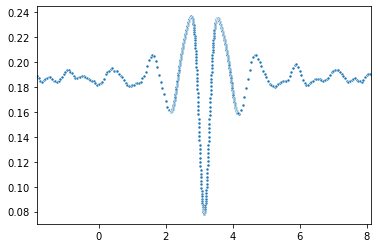

In [11]:
import numpy as np
from numba import njit


@njit(parallel=False)
def nearest_advocate_single(arr_ref: np.ndarray, arr_sig: np.ndarray, 
                            dist_max: float, dist_padding: float, regulate_paddings: bool=True):
    '''Calculates the synchronicity of two arrays of timestamps in terms of the mean of all minimal distances between each event in arr_sig and it's nearest advocate in arr_ref.
    arr_ref (np.array): Reference array or timestamps assumed to be correct
    arr_sig (np.array): Signal array of  timestamps, assumed to be shifted by an unknown constant time-delta
    dist_max (float): Maximal accepted distances, should be 1/4 of the median gap of arr_ref
    regulate_paddings (bool): Regulate non-overlapping events in arr_sig with a maximum distance of err_max, default True
    dist_padding (float): Distance assigned to non-overlapping (padding) events, should be 1/4 of the median gap of arr_ref. Only given if regulate_paddings is True
    '''
    # Assert input properties
    assert arr_ref.shape[0] > 0    # reference array must be non-empty
    assert arr_sig.shape[0] > 0    # signal array must be non-empty
    assert dist_max > 0.0          # maximal distance must be greater than 0.0
    if regulate_paddings:
        assert dist_padding > 0.0  # maximal distance for paddings must be greater than 0.0

    # store the lengths of the arrays
    l_arr_ref = len(arr_ref)
    l_arr_sig = len(arr_sig)
            
    ref_idx = 0              # index for arr_ref
    sig_idx = 0              # index for arr_sig
    counter = 0              # number of advocate events
    cum_distance = 0.0       # cumulative distances between advocate events
    
    # Step 1: cut leading reference timestamps without finding advocates
    while ref_idx+1 < l_arr_ref and arr_ref[ref_idx+1] <= arr_sig[sig_idx]:
        ref_idx += 1
        
    # return dist_max, if arr_ref ends before arr_sig starts
    if ref_idx+1 == l_arr_ref:
        return dist_max
    
    # Case: arr_ref[ref_idx] < arr_sig[sig_idx] < arr_ref[ref_idx+1]
    assert arr_ref[ref_idx+1] > arr_sig[sig_idx]
    
    # Step 2: count leading signal timestamps with finding advocates
    while sig_idx < l_arr_sig and arr_sig[sig_idx] < arr_ref[ref_idx]:
        # Invariant: arr_ref[ref_idx] < arr_sig[sig_idx] < arr_ref[ref_idx+1]
        if regulate_paddings:
            cum_distance += min(arr_ref[ref_idx]-arr_sig[sig_idx], dist_padding)
            counter += 1
        sig_idx += 1
        
    # return dist_max, if arr_sig ends before arr_ref starts
    if sig_idx == l_arr_sig:
        return dist_max     
    
    # Step 3 (regular case) and step 4 (match trailing signal timestamps)
    while sig_idx < l_arr_sig:
        # Step 3: regular case
        if arr_sig[sig_idx] < arr_ref[-1]:
            # forward arr_ref and then arr_sig until regalar case
            while ref_idx+1 < l_arr_ref and arr_ref[ref_idx+1] <= arr_sig[sig_idx]:
                ref_idx += 1
            if ref_idx+1 >= l_arr_ref: 
                sig_idx += 1
                continue
            # Invariant: arr_ref[ref_idx] < arr_sig[sig_idx] < arr_ref[ref_idx+1]
            # assert arr_ref[ref_idx] <= arr_sig[sig_idx]
            # assert arr_sig[sig_idx] < arr_ref[ref_idx+1]
            
            cum_distance += min(arr_sig[sig_idx]-arr_ref[ref_idx], arr_ref[ref_idx+1]-arr_sig[sig_idx], dist_max) 
            counter += 1
        # Step 4: match trailing reference timestamps with last signal timestamp
        elif regulate_paddings:  
            # Invariant: arr_ref[ref_idx+1] <= arr_sig[sig_idx], given by the else case
            if arr_sig[sig_idx]-arr_ref[ref_idx+1] < dist_padding:
                cum_distance += arr_sig[sig_idx]-arr_ref[ref_idx+1]
                counter += 1
            else: 
                # case with only dist_padding increments from now on
                cum_distance += (l_arr_sig - sig_idx) * dist_padding
                counter += (l_arr_sig - sig_idx)
                break # stop, because the last values can be aggregated
                
        sig_idx += 1
    
    # return mean cumulative distance between found advocate events
    return cum_distance / counter


@njit(parallel=False)
def nearest_advocate(arr_ref: np.ndarray, arr_sig: np.ndarray, 
                     td_min: float, td_max: float, td_prox=None, sps: float=10, sparse_factor: int=1, 
                     dist_max: float=0.0, regulate_paddings: bool=True, dist_padding: float=0.0,
                    finesearch: bool=True):
    '''Calculates the synchronicity of two arrays of timestamps for a search space between td_min and td_max with a precision of 1/sps. The synchronicity is given by the mean of all minimal distances between each event in arr_sig and it's nearest advocate in arr_ref.
    arr_ref (np.array): Reference array or timestamps assumed to be correct
    arr_sig (np.array): Signal array of  timestamps, assumed to be shifted by an unknown constant time-delta
    td_min (float): lower bound of the search space for the time-shift
    td_max (float): upper bound of the search space for the time-shift
    sps (int): number of investigated time-shifts per second, should be higher than 10 times the number of median gap of arr_ref (default 10).
    sparse_factor (int): factor for the sparseness of arr_sig for the calculation, higher is faster but may be less accurate (default 1)
    dist_max (None, float): Maximal accepted distances, default None: 1/4 of the median gap of arr_ref
    dist_padding (None, float): Assumed distances of non-overlapping (padding) matches, default None: 1/4 of the median gap of arr_ref
    regulate_paddings (bool): regulate non-overlapping events in arr_sig with a maximum distance of err_max
    '''
    # set the default values for dist_max, dist_padding relative if not set
    # TODO improve default value: min(np.median(np.diff(arr_sig)), np.median(np.diff(arr_ref))) / 4
    if dist_max <= 0.0:
        dist_max = np.median(np.diff(arr_ref))/4
    if dist_padding <= 0.0:
        dist_padding = np.median(np.diff(arr_ref))/4
    if td_prox is None:
        td_prox = 1.5  # * np.median(np.diff(arr_ref))
        
    # Random subsample and create a copy of arr_sig once, as it could lead to problems otherwise
    if sparse_factor > 1:
        probe = arr_sig[sparse_factor//2::sparse_factor].copy()
    else:
        probe = arr_sig.copy()
    
    # Create an k x 2 matrix to store the investigated time-shifts and their respective mean distance
    broad_search_n_samples = int((td_max-td_min)*sps)
    fine_search_n_samples = int(2*10*td_prox*sps)   # fine search with factor 1/10 sampling
    
    if finesearch:
        time_delays = np.empty((broad_search_n_samples+fine_search_n_samples, 2), dtype=np.float32)
        time_delays[:broad_search_n_samples, 0] = np.arange(td_min, td_max, 1/sps)[:broad_search_n_samples]
    else:
        time_delays = np.empty((broad_search_n_samples, 2), dtype=np.float32)
        time_delays[:, 0] = np.arange(td_min, td_max, 1/sps)
        
    # Calculate the mean distance for all time-shifts in the search space. 
    # The shift with the lowest mean distance is the best fit for the time-shift
    idx = 0
    while idx < broad_search_n_samples:
        # calculate the nearest advocate criteria
        time_delays[idx,1] = nearest_advocate_single(
             arr_ref, 
             probe-time_delays[idx,0],  # the signal array is shifted by a time-delta
             dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding)
        idx += 1
    
    if not finesearch:
        return time_delays
    
    # finesearch around the peak
    time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:broad_search_n_samples,1])]
    time_delays[broad_search_n_samples:, 0] = np.arange(time_shift-td_prox, time_shift+td_prox, 
                                                        1/sps/10)[:fine_search_n_samples]
    while idx < time_delays.shape[0]:
        # calculate the nearest advocate criteria
        time_delays[idx,1] = nearest_advocate_single(
             arr_ref, 
             probe-time_delays[idx,0],  # the signal array is shifted by a time-delta
             dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding)
        idx += 1 
    return time_delays

# run once before the test to just-in-time compile it
start_time = time.time()
time_delays = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig, 
                             td_min=-10, td_max=10, td_prox=1, sps=SAMPLES_PER_S, sparse_factor=1, 
                             dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX,
                              finesearch=True)
time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
print(f"Found optimum for a time shift of {time_shift:.3f}s in {time.time()-start_time:.3f}s")

sns.scatterplot(x=time_delays[:,0], y=time_delays[:,1], marker='.')
plt.xlim(time_shift-5.0, time_shift+5.0)
plt.show()

## Plot the characteristical line of one sample

In [12]:
def plot_nearest_advocate(df_nearest, lb=-10, ub=15, savepath=None, alpha=0.05, cutofflevel=0.5):
    # Plot main stuff and resulting optimum
    # df_nearest["score"] = -(df_nearest["error"] - np.median(df_nearest["error"])) / (np.median(df_nearest["error"]) - np.min(df_nearest["error"]))
    # df_nearest["probability"] = scipy.special.softmax(temperature*(df_nearest["score"]-df_nearest["error"].mean()))
    sns.lineplot(data=df_nearest, x="time-delta", y="error", color="steelblue", label="Distance")
    td_hat = df_nearest.loc[np.argmin(df_nearest["error"])]["time-delta"]
    plt.vlines(x=td_hat, ymin=0, ymax=1, color="firebrick", label=f"Shift = {td_hat:.2f}s")

    # Transform dataframe
    # df_nearest = df_nearest[(lb < df_nearest["time-delta"]) * (df_nearest["time-delta"] < ub)]
    avg = np.median(df_nearest["error"])
    df_nearest["score"] = avg - df_nearest["error"].copy()
    max_score = df_nearest["score"].max();
    df_nearest.loc[df_nearest["score"] < (cutofflevel*max_score), "score"] = 1e-9
    df_nearest["score"] /= df_nearest["score"].sum()
    sns.lineplot(data=df_nearest, x="time-delta", y="score", color="darkturquoise", label="Prob. density")
    
    # Confidence interval
    df_nearest["cumscore"] = df_nearest["score"].cumsum() / df_nearest["score"].sum()
    low_border = df_nearest.loc[df_nearest[df_nearest["cumscore"].gt(alpha/2)].index[0]]
    high_border = df_nearest.loc[df_nearest[df_nearest["cumscore"].gt(1-alpha/2)].index[0]]
    width = high_border['time-delta']-low_border['time-delta']

    # Plot statistics
    avg_prox = time_delay_df.loc[
        (td_hat+lb < time_delay_df["time-delta"]) & (time_delay_df["time-delta"] < td_hat+ub),
        "error"].mean()
    plt.hlines(y=avg_prox, xmin=td_hat+lb, xmax=td_hat+ub, color="black", label="Mean distance")
    b = (avg - df_nearest["error"].min()) #/ 2
    plt.vlines(x=low_border["time-delta"], ymin=0, ymax=1, color="black", linestyle="dashed")
    plt.vlines(x=high_border["time-delta"], ymin=0, ymax=1, color="black", linestyle="dashed", label=f"{100*(1-alpha):.0f}% conf. {width:.1f}s")
    df_peak = df_nearest[(low_border["time-delta"] <= df_nearest["time-delta"]) * (df_nearest["time-delta"] <= high_border["time-delta"])]

    plt.xlim([td_hat+lb, td_hat+ub])
    plt.ylim([-0.01, 1.1*time_delay_df["error"].max()])
    plt.title("Characteristic Curve of Nearest Advocate")
    plt.xlabel("Time shift (s)")
    plt.ylabel("Mean distance (s)")
    
    plt.legend(loc="lower right")
    if savepath:
        plt.savefig(savepath, bbox_inches = "tight")
    plt.show()

In [13]:
arr_ref, arr_sig = heart_beat_dataset[0]
arr_ref = arr_ref[:600]
arr_sig = arr_sig[:600] + np.pi

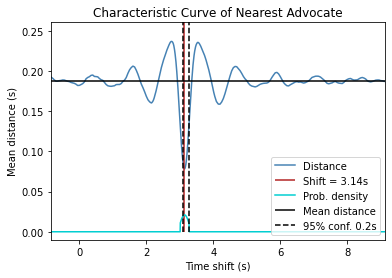

In [14]:
time_delay_df = pd.DataFrame(time_delays, columns=["time-delta", "error"])
plot_nearest_advocate(time_delay_df, 
                      lb=-4, ub=6,
                      alpha=0.05, cutofflevel=0.5, 
                      savepath="fig/real_syncplot_nearestadvocate.png")

## Frequency analysis of the result

Seems to be not important.

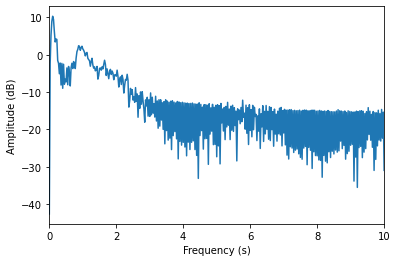

In [15]:
from scipy.fft import rfft, rfftfreq

df = time_delay_df[time_delay_df["error"] < np.median(np.diff(arr_ref)) / 2]
yf = rfft(np.array(df["error"] - df["error"].mean()))
xf = rfftfreq(len(df), 1 / SAMPLES_PER_S)

plt.plot(xf, 10*np.log10(np.abs(yf)))
plt.xlabel("Frequency (s)")
plt.ylabel("Amplitude (dB)")
plt.xlim(0, 10)
plt.show()

## Window-wise sync

In [16]:
arr_ref, arr_sig = heart_beat_dataset[1]

In [23]:
@njit
def numba_diff(x):
    return x[1:] - x[:-1]

@jit(nopython=True)
def interp_nb(x_vals, x, y):
    return np.interp(x_vals, x, y)

@njit(parallel=True)
def window_sync_parallel(arr_ref, arr_sig, td_min=-60, td_max=60, td_mid=30, sparse_factor=1, 
                dist_max=None, regulate_paddings=True, dist_padding=None, 
                window_len=50, sliding_len=25, pps=SAMPLES_PER_S):
    # make a copy because it is more robust for numba jit-compiled functions
    arr_ref = arr_ref.copy().astype(np.float32)
    arr_sig = arr_sig.copy().astype(np.float32)
        
    # define window centers and init df_results
    window_centers = np.arange(0, arr_ref.max()-arr_ref.min(), sliding_len)
    res_len = len(window_centers)
    # create randomly sized time windows for each center windows, sampled from a log-normal distribution
    window_len_samples = window_len * np.exp(np.random.normal(loc=1, scale=1, size=res_len))

    dict_results = {"index": np.nan*np.zeros(res_len, dtype=np.int32),
                    "timestamp": np.nan*np.zeros(res_len, dtype=np.float32),
                    "time-delta": np.nan*np.zeros(res_len, dtype=np.float32),
                    "min-distance": np.nan*np.zeros(res_len, dtype=np.float32),
                    "min-distance-away": np.nan*np.zeros(res_len, dtype=np.float32),
                    "min-distance-difference": np.nan*np.zeros(res_len, dtype=np.float32)}
    
    # Iterate over all window_centers for multiple estimates
    min_err = 1e9
    max_delta = 0.0
    min_err_windows_ts = None
    n_kernels = int(2 * pps * np.median(numba_diff(arr_ref)) + 1)
    spectrogram_interp_xvals = np.arange(td_min, td_max, SPECTROSCOPY_XVAL_DT).astype(np.float32)
    spectrogram = np.nan * np.ones((len(window_centers), len(spectrogram_interp_xvals)), dtype=np.float32)
    # numba parallel loop
    for idx in prange(res_len):
        arr_sig_window = arr_sig[np.logical_and(arr_sig.min()+window_centers[idx]-window_len_samples[idx]/2 <= arr_sig, 
                                                arr_sig < arr_sig.min()+window_centers[idx]+window_len_samples[idx]/2)]
        nearest_results = nearest_advocate(arr_ref, arr_sig_window,
                                 td_min=td_min, td_max=td_max, sparse_factor=sparse_factor, sps=pps, 
                                 dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding)
        nearest_tds, nearest_distances = nearest_results[:,0], nearest_results[:,1]

        # calculate statistics
        td_hat = nearest_tds[np.argmin(nearest_distances)]       # time-delta with the minimal distance
        away_idx = np.abs(nearest_tds-td_hat) > td_mid           # indices of time-deltas more than td_mid away from the found minimum
        min_distance_window = np.min(nearest_distances)                 # minimal distance of all time-deltas
        min_distance_window_away = np.min(nearest_distances[away_idx])  # minimal distance of all time-deltas more than td_mid away from the minimum

        # document the results in the dict_result
        dict_results["index"][idx] = idx
        dict_results["timestamp"][idx] = window_centers[idx]
        dict_results["time-delta"][idx] = td_hat
        dict_results["min-distance"][idx] = min_distance_window
        dict_results["min-distance-away"][idx] = min_distance_window_away
        dict_results["min-distance-difference"][idx] = min_distance_window_away - min_distance_window
        
        # store the information in the spectrogram
        spectrogram[idx, :] = interp_nb(spectrogram_interp_xvals, nearest_tds, 
                                        moving_aggregation_nb(
                                            moving_aggregation_nb(nearest_distances, w=n_kernels, aggregation="min"), 
                                            w=2*n_kernels, aggregation="mean").copy())

    return dict_results, spectrogram

# test window_sync_parallel
dict_results, spectrogram = window_sync_parallel(
    arr_ref=arr_ref, arr_sig=arr_sig,
    td_min=TD_MIN, td_max=TD_MAX, sparse_factor=1, 
    dist_max=-1, regulate_paddings=True, dist_padding=-1, 
    window_len=50, sliding_len=200, pps=SAMPLES_PER_S)
pd.DataFrame({k: v for k, v in dict_results.items()}).head()

,index,timestamp,time-delta,min-distance,min-distance-away,min-distance-difference
0,0.0,0.0,-300.000000,0.296509,0.296509,0.000000
1,1.0,200.0,-300.000000,0.296509,0.296509,0.000000
2,2.0,400.0,-293.610016,0.172995,0.257438,0.084443
3,3.0,600.0,0.145000,0.182263,0.211011,0.028748
4,4.0,800.0,0.135000,0.113804,0.155842,0.042039


In [83]:
td_min=-60; td_max=60; td_mid=30; sparse_factor=1; 
dist_max=-1; regulate_paddings=True; dist_padding=-1; 
window_len=50; sliding_len=25; bandwidth=30; sps_adaption_factor=1.0; pps=SAMPLES_PER_S;
parallelize=False; verbose=5; save_fig=None;

In [84]:
# define window centers and init df_results
window_centers = np.arange(0, arr_ref.max()-arr_ref.min(), sliding_len)
res_len = len(window_centers)
print(f"Starting the window-wise synchronization with {res_len} windows, window_len: {window_len}, sliding_len: {sliding_len}")

dict_results = {"index": np.nan*np.zeros(res_len, dtype=np.int32),
                "timestamp": np.nan*np.zeros(res_len, dtype=np.float32),
                "time-delta": np.nan*np.zeros(res_len, dtype=np.float32),
                "min-distance": np.nan*np.zeros(res_len, dtype=np.float32),
                "min-distance-away": np.nan*np.zeros(res_len, dtype=np.float32),
                "min-distance-difference": np.nan*np.zeros(res_len, dtype=np.float32)}

Starting the window-wise synchronization with 1157 windows, window_len: 50, sliding_len: 25


In [90]:
# Iterate over all window_centers for multiple estimates
min_err = 1e9
max_delta = 0.0
min_err_windows_ts = None
n_kernels = int(2 * SAMPLES_PER_S * np.median(numba_diff(arr_ref)) + 1)
spectrogram_interp_xvals = np.arange(td_min, td_max, SPECTROSCOPY_XVAL_DT).astype(np.float32)
spectrogram = np.nan * np.ones((len(window_centers), len(spectrogram_interp_xvals)), dtype=np.float32)
for idx, window_center in enumerate(window_centers):
    # arr_ref_window = arr_ref
    window_len_sample = window_len * np.exp(np.random.normal(loc=1, scale=1, size=1)[0])
    # if window_center-window_len_sample/2 < 0 or window_center+window_len_sample/2 > arr_sig.max()-arr_sig.min():
    #     continue
    arr_sig_window = arr_sig[np.logical_and(arr_sig.min()+window_center-window_len_sample/2 <= arr_sig, 
                                           arr_sig < arr_sig.min()+window_center+window_len_sample/2)]
    # find nearest-advocates in the windows
    print(arr_sig_window)
    print(arr_ref)
    nearest_results = nearest_advocate(arr_ref.astype(np.float32), arr_sig_window.astype(np.float32),
                                 td_min=td_min, td_max=td_max, sparse_factor=sparse_factor, sps=pps, 
                                 dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding)
    nearest_tds, nearest_distances = nearest_results[:,0], nearest_results[:,1]

    # calculate statistics
    td_hat = nearest_tds[np.argmin(nearest_distances)]       # time-delta with the minimal distance
    away_idx = np.abs(nearest_tds-td_hat) > td_mid           # indices of time-deltas more than td_mid away from the found minimum
    min_distance_window = np.min(nearest_distances)                 # minimal distance of all time-deltas
    min_distance_window_away = np.min(nearest_distances[away_idx])  # minimal distance of all time-deltas more than td_mid away from the minimum

    # document the results in the dict_result
    dict_results["index"][idx] = idx
    dict_results["timestamp"][idx] = window_centers[idx]
    dict_results["time-delta"][idx] = td_hat
    dict_results["min-distance"][idx] = min_distance_window
    dict_results["min-distance-away"][idx] = min_distance_window_away
    dict_results["min-distance-difference"][idx] = min_distance_window_away - min_distance_window

    # check how well it is globally
    if td_hat != TD_MIN and min_distance_window_away - min_distance_window > max_delta:
        max_delta = min_distance_window_away - min_distance_window
        # min_distance_windows_ts = window_center
        postfix1 = "*"
    else:
        postfix1 = ""
    if td_hat != TD_MIN and min_distance_window < min_err:
        min_err = min_distance_window
#         min_err_slice_idx = slice_idx_start
        postfix2 = "+"
    else:
        postfix2 = ""

    spectrogram[idx, :] = np.interp(spectrogram_interp_xvals, nearest_tds,
                                    moving_aggregation(
                                        moving_aggregation(nearest_distances, w=n_kernels, aggregation="min"), 
                                        w=2*n_kernels, aggregation="mean"))

    if verbose >= 2:
        print(f"  Window {idx:3d} at: ({window_center:.1f}s +- {window_len_sample/2:.2f}s),\t", end="")
        print(f"Minimum at {td_hat:.3f}s,\t score: {min_distance_window:.6f} ", end="")
        print(f"others: {min_distance_window_away:.6f}, \tdiff: {min_distance_window_away-min_distance_window:.6f} " + postfix1 + postfix2)
    break

[  0.994   1.748   2.484   3.172   3.864   4.574   5.3     6.038   6.844
   7.752   8.644   9.508  10.318  11.12   11.922  12.778  13.694  14.598
  15.534  16.424  17.256  18.08   18.88   19.666  20.44   21.238  22.062
  22.89   23.664  24.408  25.164  25.92   26.672  27.406  28.18   28.966
  29.742  30.53   31.348  32.208  33.072  33.902  34.734  35.58   36.494
  37.418  38.32   39.186  40.052  40.92   41.79   42.648  43.488  44.326
  45.228  46.164  47.086  47.978  48.944  49.918  50.9    51.782  52.578
  53.354  54.164  55.042  55.89   56.802  57.7    58.56   59.4    60.232
  61.074  61.906  62.716  63.476  64.188  64.902  65.63   66.358  67.056
  67.764  68.498  69.28   70.114  71.02   71.95   72.816  73.72   74.614
  75.486  76.336  77.28   78.218  79.174  80.098  80.982  81.88   82.754
  83.552  84.32   85.04   85.74   86.416  87.076  87.732  88.366  88.996
  90.804  91.4    92.012  92.634  93.26   93.92   94.61   95.318  96.07
  96.806  97.518  98.224  98.924  99.602 100.298 101

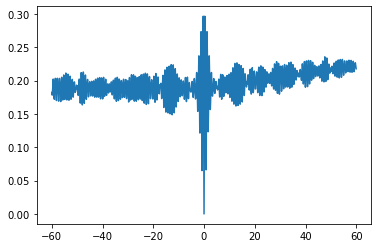

In [89]:
plt.plot(nearest_results[:,0], nearest_results[:,1])

In [78]:
nearest_results[np.argmin(nearest_results[:,1])]

array([0., 0.], dtype=float32)

In [24]:
def window_sync(file_ref, file_sig, td_min=-60, td_max=60, td_mid=30, sparse_factor=1, 
                dist_max=None, regulate_paddings=True, dist_padding=None, 
                window_len=50, sliding_len=25, bandwidth=30, sps_adaption_factor=1.0, pps=SAMPLES_PER_S, 
                parallelize=False, verbose=0, save_fig=None):    
    # load arrays, make a copy because it is more robust for numba jit-compiled functions
    if isinstance(file_ref, str):
        arr_ref = load_file(filename=file_ref, sps_adaption_factor=1.0, 
                            filter_large_dist=FILTER_LARGE_DIST).copy()  # reference has always sps_adaption_factor=1.0
    else:
        arr_ref = file_ref.copy()
    
    if isinstance(file_sig, str):
        arr_sig = load_file(filename=file_sig, sps_adaption_factor=sps_adaption_factor, filter_large_dist=FILTER_LARGE_DIST).copy()   
    else:
        arr_sig = file_sig.copy()
    
    # parallelize in numba
    if parallelize:
        # return None
        dict_results, spectrogram = window_sync_parallel(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=td_min, td_max=td_max, td_mid=td_mid, sparse_factor=sparse_factor, pps=pps,
            dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding,
            window_len=window_len, sliding_len=sliding_len)
    else:        
        # define window centers and init df_results
        window_centers = np.arange(0, arr_ref.max()-arr_ref.min(), sliding_len)
        res_len = len(window_centers)
        print(f"Starting the window-wise synchronization with {res_len} windows, window_len: {window_len}, sliding_len: {sliding_len}")

        dict_results = {"index": np.nan*np.zeros(res_len, dtype=np.int32),
                        "timestamp": np.nan*np.zeros(res_len, dtype=np.float32),
                        "time-delta": np.nan*np.zeros(res_len, dtype=np.float32),
                        "min-distance": np.nan*np.zeros(res_len, dtype=np.float32),
                        "min-distance-away": np.nan*np.zeros(res_len, dtype=np.float32),
                        "min-distance-difference": np.nan*np.zeros(res_len, dtype=np.float32)}

        # Iterate over all window_centers for multiple estimates
        min_err = 1e9
        max_delta = 0.0
        min_err_windows_ts = None
        n_kernels = int(2 * SAMPLE_RATE_DT * np.median(numba_diff(arr_ref)) + 1)
        spectrogram_interp_xvals = np.arange(td_min, td_max, SPECTROSCOPY_XVAL_DT).astype(np.float32)
        spectrogram = np.nan * np.ones((len(window_centers), len(spectrogram_interp_xvals)), dtype=np.float32)
        for idx, window_center in enumerate(window_centers):
            # arr_ref_window = arr_ref
            window_len_sample = window_len * np.exp(np.random.normal(loc=1, scale=1, size=1)[0])
            # if window_center-window_len_sample/2 < 0 or window_center+window_len_sample/2 > arr_sig.max()-arr_sig.min():
            #     continue
            arr_sig_window = arr_sig[np.logical_and(arr_sig.min()+window_center-window_len_sample/2 <= arr_sig, 
                                                   arr_sig < arr_sig.min()+window_center+window_len_sample/2)]

            # find nearest-advocates in the windows
            nearest_results = nearest_advocate(arr_ref.astype(np.float32), arr_sig_window.astype(np.float32),
                                         td_min=td_min, td_max=td_max, sparse_factor=sparse_factor, sps=pps, 
                                         dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding)
            nearest_tds, nearest_distances = nearest_results[:,0], nearest_results[:,1]

            # calculate statistics
            td_hat = nearest_tds[np.argmin(nearest_distances)]       # time-delta with the minimal distance
            away_idx = np.abs(nearest_tds-td_hat) > td_mid           # indices of time-deltas more than td_mid away from the found minimum
            min_distance_window = np.min(nearest_distances)                 # minimal distance of all time-deltas
            min_distance_window_away = np.min(nearest_distances[away_idx])  # minimal distance of all time-deltas more than td_mid away from the minimum

            # document the results in the dict_result
            dict_results["index"][idx] = idx
            dict_results["timestamp"][idx] = window_centers[idx]
            dict_results["time-delta"][idx] = td_hat
            dict_results["min-distance"][idx] = min_distance_window
            dict_results["min-distance-away"][idx] = min_distance_window_away
            dict_results["min-distance-difference"][idx] = min_distance_window_away - min_distance_window
            
            # check how well it is globally
            if td_hat != TD_MIN and min_distance_window_away - min_distance_window > max_delta:
                max_delta = min_distance_window_away - min_distance_window
                # min_distance_windows_ts = window_center
                postfix1 = "*"
            else:
                postfix1 = ""
            if td_hat != TD_MIN and min_distance_window < min_err:
                min_err = min_distance_window
        #         min_err_slice_idx = slice_idx_start
                postfix2 = "+"
            else:
                postfix2 = ""

            spectrogram[idx, :] = np.interp(spectrogram_interp_xvals, nearest_tds,
                                            moving_aggregation(
                                                moving_aggregation(nearest_distances, w=n_kernels, aggregation="min"), 
                                                w=2*n_kernels, aggregation="mean"))

            if verbose >= 2:
                print(f"  Window {idx:3d} at: ({window_center:.1f}s +- {window_len_sample/2:.2f}s),\t", end="")
                print(f"Minimum at {td_hat:.3f}s,\t score: {min_distance_window:.6f} ", end="")
                print(f"others: {min_distance_window_away:.6f}, \tdiff: {min_distance_window_away-min_distance_window:.6f} " + postfix1 + postfix2)

    # aggregate the results
    df_results = pd.DataFrame({k: v for k, v in dict_results.items()})
    min_distance_diff_window_ts = dict_results["timestamp"][np.argmax(dict_results["min-distance-difference"])]
    
    ## Filter the results and perform a robust linear regression
    # filter time-deltas with td_min     
    df_results.dropna(inplace=True)   
    df_results = df_results[df_results["time-delta"] != td_min]
    
    # find nearest-advocates in the best windows to get the results    
    arr_ref_window = arr_ref
    arr_sig_window = arr_sig[np.logical_and(arr_sig.min()+min_distance_diff_window_ts <= arr_sig, 
                                           arr_sig < arr_sig.min()+min_distance_diff_window_ts+sliding_len)]
    df_nearest = pd.DataFrame(
        nearest_advocate(arr_ref_window.astype(np.float32), arr_sig_window.astype(np.float32),
                                 td_min=td_min, td_max=td_max, sparse_factor=sparse_factor, sps=pps, 
                                 dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding),
        columns=["time-delta", "distance"])
    td_hat = df_nearest.loc[np.argmin(df_nearest["distance"])]["time-delta"]
    df_away = df_nearest.loc[np.abs(df_nearest["time-delta"]-td_hat) > td_mid]
    
    # estimattion of a more acurate sps and time-delta    
    # filter on internal criterion measure
    df_results_filt = df_results[df_results["min-distance-difference"] >= df_results["min-distance-difference"].quantile(0.25)]
    df_results_filt = df_results_filt[df_results_filt["time-delta"] <= np.median(df_results_filt["time-delta"])+bandwidth]
    df_results_filt = df_results_filt[df_results_filt["time-delta"] >= np.median(df_results_filt["time-delta"])-bandwidth]
        
    # filter on KDE cluster criterion
    kde = KernelDensity(kernel='cosine', bandwidth=bandwidth).fit(df_results[["time-delta"]].values)
    time_deltas = np.linspace(td_min, td_max, int(td_max-td_min+1)).reshape(-1, 1)
    kde_opt = time_deltas[np.argmax(kde.score_samples(time_deltas))][0]
    df_results_filt = df_results_filt.loc[(kde_opt-bandwidth < df_results_filt["time-delta"]) & (df_results_filt["time-delta"] < kde_opt+bandwidth)]
    
    # perform a robust linear regression
    model = sklearn.linear_model.TheilSenRegressor(random_state=1)  # HuberRegressor(fit_intercept=True)
    # TODO check if df_results_filt works better here
    model.fit(X=df_results_filt[["timestamp"]].values, y=df_results_filt["time-delta"].values)
    n_pred_points = 101; x = np.linspace(0, df_results["timestamp"].values[-1], n_pred_points) 
    pred_y = model.predict(x.reshape(-1,1))
    
    # calculate the stats of the linear model
    corr_coef = np.corrcoef(df_results["time-delta"].values, model.predict(df_results[["timestamp"]].values))[0,1]
    R_sq = corr_coef**2
    rmse = np.sqrt(np.mean((df_results["time-delta"].values - model.predict(df_results[["timestamp"]].values))**2))
    mae = np.mean(np.abs(df_results["time-delta"].values - model.predict(df_results[["timestamp"]].values)))
    if verbose >= 2:
        print(f"The coefficient of determination R²={R_sq:.4f}, the RMSE={rmse:.6f}, the MAE={mae:.6f}")
    
    # estimate the time-delta and sps
    td_hat = pred_y[0]
    td_hat_median = np.median(pred_y)
    sps_adaption_factor = sps_adaption_factor - sps_adaption_factor * model.coef_[0]
    if verbose >= 2:
        print(f"The optimal time-delta is at {td_hat:.3f} s and the sample rate factor at {sps_adaption_factor:.3f}")
        
    # Plot the result
    if verbose >= 1.0 or save_fig:
        plt.cla()
        # df_results["diff-rank"] = df_results["diff-err"].rank()
        sns.scatterplot(data=df_results, x="timestamp", y="time-delta", color="steelblue", label="Time-Delay", marker="o")
        # sns.scatterplot(data=df_results_filt, x="timestamp", y="time-delta", color="limegreen", label="Time-Delta robust")
        sns.lineplot(x=x, y=pred_y, color="firebrick", label="Robust Linear Fit")
        plt.xlabel("Window time (s)")
        plt.ylabel("Estimated Time-Delays (s)")
        td_mean = np.median(df_results["time-delta"])
        td_iqr = np.quantile(df_results["time-delta"], 0.75) - np.quantile(df_results["time-delta"], 0.25)
        plt.ylim(max(td_min, td_mean-2*td_iqr-1), min(td_max, td_mean+2*td_iqr+1))
        if save_fig:
            plt.savefig(save_fig)
        if verbose >= 1.5:
            plt.show()

    print()
    return sps_adaption_factor, td_hat, td_hat_median, df_results, spectrogram, rmse, mae

In [26]:
sps_adaption_factor, td_hat, td_hat_median, df_results, spectrogram, rmse, mae = window_sync(
    file_ref=arr_ref, #[:1000],
    file_sig=arr_sig, #[:1000],
    td_min=TD_MIN, td_max=TD_MAX, sparse_factor=1, 
    dist_max=-1.0, regulate_paddings=True, dist_padding=-1.0, 
    window_len=WINDOW_LENGTH, sliding_len=SLIDING_LENGTH, bandwidth=BANDWIDTH, pps=SAMPLES_PER_S,
    sps_adaption_factor=1.0, verbose=5, parallelize=True, # running parallel does not support high verbose mode
    save_fig="default_round-1_timedelta.png")
sps_adaption_factor, td_hat, td_hat_median, rmse, mae

AssertionError: 

In [207]:
spectrogram_df = pd.DataFrame(spectrogram.T, index=np.arange(TD_MIN, TD_MAX, (TD_MAX-TD_MIN)/spectrogram.shape[1])).iloc[::-1]
spectrogram_df_normed = spectrogram_df.apply(lambda x: (x-spectrogram_df.mean(axis=0))/spectrogram_df.std(axis=0), axis=1)

ax = sns.heatmap(spectrogram_df_normed, linewidth=0.0, cmap="BrBG")
ax.set_xlabel("Window")
ax.set_ylabel("Time-Delta (s)")
n_yticks = 10; ax.set_yticks(np.arange(0, len(spectrogram_df), 20*n_yticks), labels=[f"{i:.1f}" for i in np.arange(TD_MAX, TD_MIN, -20)])

plt.show()

KeyboardInterrupt: 

In [ ]:
spectrogram_mean_df = spectrogram_df[spectrogram_df < spectrogram_df.max()].mean(axis=1)

sns.lineplot(data=spectrogram_mean_df,color="steelblue", label="Mean distance over windows")
sns.scatterplot(x=[spectrogram_mean_df.index[spectrogram_mean_df.argmin()]], y=[spectrogram_mean_df.iloc[spectrogram_mean_df.argmin()]], 
                color="firebrick", label=f"Minimal distance: {spectrogram_mean_df.index[spectrogram_mean_df.argmin()]:.2f}s")
plt.xlabel("Time-Delta (s)")
plt.xlabel("Mean distance over windows (s)")
plt.legend(loc="upper right")
plt.show()

### Aggregate windows back together

In [ ]:
batchsize = 10
spectrogram_mean_batched_df = pd.DataFrame(spectrogram.T[:,::batchsize], 
                                           index=np.arange(TD_MIN, TD_MAX, (TD_MAX-TD_MIN)/spectrogram.shape[1])).iloc[::-1]

for idx_batched, idx_col in enumerate(range(0, spectrogram_df.shape[1], batchsize)):
    df = spectrogram_df.iloc[:,idx_col:idx_col+batchsize]
    spectrogram_mean_batched_df.iloc[:,idx_batched] = df[df < df.max()].mean(axis=1)
    

In [ ]:
# spectrogram_df = pd.DataFrame(spectrogram.T, index=np.arange(TD_MIN, TD_MAX, (TD_MAX-TD_MIN)/spectrogram.shape[1]))
spectrogram_mean_batched_df_normed = spectrogram_mean_batched_df.apply(
    lambda x: (x-spectrogram_mean_batched_df.mean(axis=0))/spectrogram_mean_batched_df.std(axis=0), axis=1)

ax = sns.heatmap(spectrogram_mean_batched_df_normed, linewidth=0.0, cmap="BrBG")
ax.set_xlabel("Window")
ax.set_ylabel("Time-Delta (s)")
n_yticks = 10
ax.set_yticks(np.arange(0, len(spectrogram_mean_batched_df), 20*n_yticks), labels=[f"{i:.1f}" for i in np.arange(TD_MAX, TD_MIN, -20)])

plt.show()

In [ ]:
spectrogram_mean_df = spectrogram_mean_batched_df[spectrogram_mean_batched_df < spectrogram_mean_batched_df.max()].mean(axis=1)

sns.lineplot(data=spectrogram_mean_df,color="steelblue", label="Mean distance over windows")
sns.scatterplot(x=[spectrogram_mean_df.index[spectrogram_mean_df.argmin()]], y=[spectrogram_mean_df.iloc[spectrogram_mean_df.argmin()]], 
                color="firebrick", label=f"Minimal distance: {spectrogram_mean_df.index[spectrogram_mean_df.argmin()]:.2f}s")
plt.xlabel("Time-Delta (s)")
plt.xlabel("Mean distance over windows (s)")
plt.legend(loc="upper right")
plt.show()